# Model Performance

## Preparation

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from common_model_eicu import COMPACT_COLUMNS, SEED, CV_FOLDS, \
    get_full_data, cv
from common_eicu import KEY_FLAG, CATEGORICAL_COLUMNS, KEY_IDENTITY

In [33]:
df_data = get_full_data()
X_full = df_data.drop(columns=[KEY_FLAG])
X_compact = df_data[COMPACT_COLUMNS]
y_raw_true = df_data[KEY_FLAG].ravel()
groups = df_data[KEY_IDENTITY].ravel()

In [35]:
model_full = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS,
    task_type='GPU',
    devices='0',
    boosting_type='Plain',
    metric_period=50,
    random_state=SEED,
    verbose=False,
)

In [36]:
catboost_model_compact = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS_COMPACT,
    task_type='GPU',
    devices='0',
    metric_period=METRIC_PERIOD,
    random_state=SEED,
    logging_level='Silent',
    boosting_type='Plain',
    # bagging_temperature=1.0,
    depth=6,
    iterations=350,
    l2_leaf_reg=17.6845,
    learning_rate=0.0282,
)

In [83]:
KEY_PREDICTION = 'prediction'


def generate_prediction_folds(model, X):

    folds = []

    for train_index, test_index in cv.split(X, y_raw_true, groups):

        print(f'Generating fold #{len(folds)}...')

        X_train = X.loc[train_index, :]
        y_train = y_raw_true[train_index]

        X_test = X.loc[test_index, :]
        y_test = y_raw_true[test_index]

        model.fit(X_train, y_train)
        y_prediction = model.predict(X_test)

        df_fold = X_test.copy()
        df_fold[KEY_FLAG] = y_test
        df_fold[KEY_PREDICTION] = y_prediction
        folds.append(df_fold)

    return folds

In [ ]:
folds_full = generate_prediction_folds(model_full, X_full)

In [85]:
folds_compact = generate_prediction_folds(model_compact, X_compact)

Generating fold #0...
Generating fold #1...
Generating fold #2...
Generating fold #3...
Generating fold #4...
Generating fold #5...
Generating fold #6...
Generating fold #7...
Generating fold #8...
Generating fold #9...


## Plot

In [253]:
def plot_scores(*, labels, score_lists, area_color, line_color, line_fmt, legend, ax):
    mean = np.array([scores.mean() for scores in score_lists])
    upper = np.array([scores.max() for scores in score_lists])
    lower = np.array([scores.min() for scores in score_lists])
    ax.fill_between(labels, lower, upper, color=area_color)
    ax.plot(labels, mean, line_fmt, color=line_color, label=legend)


PLOT_SPLITS = 5


def plot_performance(column, ax, *, int_labels=False, rotate_labels=False):

    score_lists_full = []
    score_lists_compact = []
    labels = []

    if column in CATEGORICAL_COLUMNS:

        unique_values = df_data[column].unique()
        labels_full = [str(value) for value in unique_values]

        for value in unique_values:

            scores_full = []
            for fold in folds_full:
                mask = fold[column] == value
                fold_filtered = fold.loc[mask]
                if not len(fold_filtered):
                    continue
                y_true = fold_filtered[KEY_FLAG].ravel()
                # if len(np.unique(y_true)) <= 1:
                #     # AUC for single-value y_true is not defined.
                #     continue
                y_prediction = fold_filtered[KEY_PREDICTION].ravel()
                score = accuracy_score(y_true, y_prediction)
                scores_full.append(score)

            scores_compact = []
            for fold in folds_compact:
                mask = fold[column] == value
                fold_filtered = fold.loc[mask]
                if not len(fold_filtered):
                    continue
                y_true = fold_filtered[KEY_FLAG].ravel()
                # if len(np.unique(y_true)) <= 1:
                #     # AUC for single-value y_true is not defined.
                #     continue
                y_prediction = fold_filtered[KEY_PREDICTION].ravel()
                score = accuracy_score(y_true, y_prediction)
                scores_compact.append(score)

            if len(scores_compact):
                score_lists_full.append(np.array(scores_full))
                score_lists_compact.append(np.array(scores_compact))
                labels.append(labels_full[i])

    else:

        values = df_data[column]
        min_value = values.min()
        max_value = values.max()
        separators = np.linspace(min_value, max_value, PLOT_SPLITS + 1)
        label_template = '{:.0f}-{:.0f}' if int_labels else '{:.2f}-{:.2f}'
        labels_full = [
            label_template.format(separators[i], separators[i + 1])
            for i in range(PLOT_SPLITS)
        ]

        for i in range(PLOT_SPLITS):

            lower = separators[i]
            upper = separators[i + 1]

            scores_full = []
            for fold in folds_full:
                if upper == max_value:
                    mask = (fold[column] >= lower) & (fold[column] <= upper)
                else:
                    mask = (fold[column] >= lower) & (fold[column] < upper)
                fold_filtered = fold.loc[mask]
                if not len(fold_filtered):
                    continue
                y_true = fold_filtered[KEY_FLAG].ravel()
                # if len(np.unique(y_true)) <= 1:
                #     # AUC for single-value y_true is not defined.
                #     continue
                y_prediction = fold_filtered[KEY_PREDICTION].ravel()
                score = accuracy_score(y_true, y_prediction)
                scores_full.append(score)

            scores_compact = []
            for fold in folds_compact:
                if upper == max_value:
                    mask = (fold[column] >= lower) & (fold[column] <= upper)
                else:
                    mask = (fold[column] >= lower) & (fold[column] < upper)
                fold_filtered = fold.loc[mask]
                if not len(fold_filtered):
                    continue
                y_true = fold_filtered[KEY_FLAG].ravel()
                # if len(np.unique(y_true)) <= 1:
                #     # AUC for single-value y_true is not defined.
                #     continue
                y_prediction = fold_filtered[KEY_PREDICTION].ravel()
                score = accuracy_score(y_true, y_prediction)
                scores_compact.append(score)

            if len(scores_compact):
                score_lists_full.append(np.array(scores_full))
                score_lists_compact.append(np.array(scores_compact))
                labels.append(labels_full[i])

    plot_scores(
        labels=labels,
        score_lists=score_lists_full,
        area_color='#39F2',
        line_color='#39F',
        line_fmt='s-',
        legend='Full',
        ax=ax,
    )

    plot_scores(
        labels=labels,
        score_lists=score_lists_compact,
        area_color='#F932',
        line_color='#F93',
        line_fmt='^-',
        legend='Compact',
        ax=ax,
    )

    ax.grid(color='#DDD')
    ax.set_ylabel('accuracy')
    ax.set_xlabel(column)
    # ax.set_ylim((0.8, 1.0))
    ax.legend(loc='lower right')

    if rotate_labels:
        labels = ax.get_xticklabels()
        for label in labels:
            label.set_rotation(10)

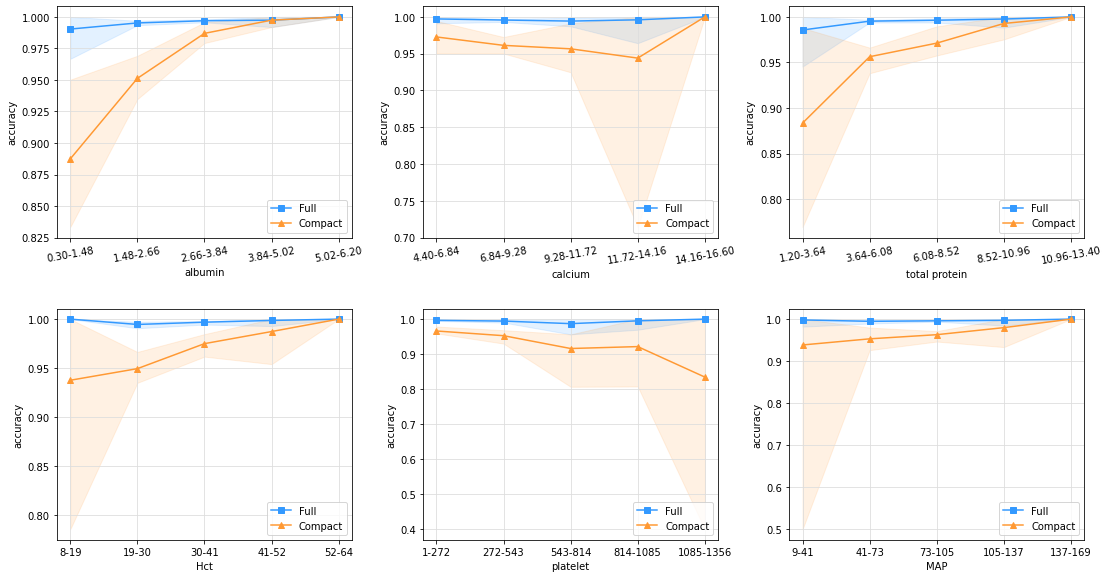

In [254]:
fig = plt.figure(figsize=(15, 8))
axes = fig.subplots(2, 3)

fig.tight_layout(w_pad=4.0, h_pad=5.0)

# plot_performance('offset', axes[0, 0], rotate_labels=True)
plot_performance('albumin', axes[0, 0], rotate_labels=True)
plot_performance('calcium', axes[0, 1], rotate_labels=True)
plot_performance('total protein', axes[0, 2], rotate_labels=True)
plot_performance('Hct', axes[1, 0], int_labels=True)
plot_performance('platelet', axes[1, 1], int_labels=True)
plot_performance('MAP', axes[1, 2], int_labels=True)

## THE END